# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw4'

/content/gdrive/My Drive/CSE527 Computer Vision/Garg_Utkarsh_112672834_hw4


In [0]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50

  
# Write your Data Normalization code here
# norm data to zero-centered
# # normalize img pixels to [-1, 1]

def img_norm(img):
  return 2 * (np.float32(img) / 255 - 0.5) 
 


def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
  
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

   
    if zero_centered:
        img_norm(img) 

    if rotate_90:
      rotated_img= [np.rot90(img,3) for img in data]    ##np.rot90 does k rotations in anticlockwise direction. Here k=3(for 90deg clockwise).
      data.extend(rotated_img)
      labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Bedroom', 1: 'Highway', 2: 'Office', 3: 'Forest', 4: 'Industrial', 5: 'Street', 6: 'Flower', 7: 'LivingRoom', 8: 'Kitchen', 9: 'Mountain', 10: 'Coast', 11: 'TallBuilding', 12: 'Suburb', 13: 'InsideCity', 14: 'Store', 15: 'OpenCountry'} 


In [0]:
## load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
9600
50
Finish loading 192 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class

In [0]:
#Saving trainloader_small and testloader_small using Pickle.
# file = open('train_data.pkl','wb')
# pickle.dump(trainloader_small, file)
# file.close()

# file = open('test_data.pkl','wb')
# pickle.dump(testloader_small, file)
# file.close()



Highway


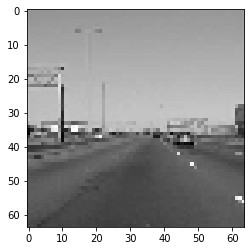

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
print(torch.cuda.is_available())
gpu_dtype = torch.cuda.FloatTensor
torch.set_grad_enabled(True)

True


## Defining Helper Functions For Training/Evaluating CNN Models

In [0]:
import torch.optim as optim
import copy
dtype = torch.FloatTensor

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()


##Training the CNN below:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 2):
    print('Training Model...')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
    

        for i in range(len(dataloader)):
            inputs = Variable(dataloader[i][0].cuda())
            labels = Variable(dataloader[i][1].cuda().long())

        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('[Epoch %d] loss: %.10f' %(epoch + 1, running_loss / len(dataloader)))
        running_loss=0.0        

    print('\nFinished Training')

def check_accuracy(model, dataloader):

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i in range(len(dataloader)):
            images = Variable(dataloader[i][0].cuda())
            labels = Variable(dataloader[i][1].cuda().long())
            outputs=model(images)
     
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('\nAccuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    
##Which class performed well!
def classification_perf(model,dataloader):
    print('\nClass wise Accuracy Performance:\n')
    class_correct = list(0. for i in range(16))
    class_total = list(0. for i in range(16))
    with torch.no_grad():
        for i in range(len(dataloader)):
            images = Variable(dataloader[i][0].cuda())
            labels = Variable(dataloader[i][1].cuda().long())
            outputs=model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(50):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(16):
        print('Accuracy of %5s : %2d %%' % (
            class_names[i], 100 * class_correct[i] / class_total[i]))
        
##Saving Model

# PATH = './cnn_net.pth'
# torch.save(net.state_dict(), PATH)

**We are using below techniques to scale our training images to allow better training set for the Neural Network:**

**Data augmentation:** We have used augment=True , thereby increasing the no. of training images by incorporating Mirrored images of the original set as well.

**Data normalization:** We have normalised our data values (images) in the range [-1,1] using img_norm().

To add to this we have also added Rotated images(rotate_90=True) by applying np.rot90() to our images, thereby increasing the total image count to 9600 for training set.


##Model 1 : Simple Model with 1 Convolution and 2 Linear Layers

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=9)
        self.fc1 = nn.Linear(in_features=32*56*56,out_features=120)
        self.out= nn.Linear(in_features=120,out_features=16)

    def forward(self, x):
      # (1) Input Layer:
        x=x

      # (2) 1st Hidden Conv Layer:
        x = self.conv1(x)
        x = F.relu(x)
       
      # (3) 1st Hidden Linear Layer:
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
     
      # (4) Final Output Layer:
        x = self.out(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

model1 = Net()
print(model1)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=16, bias=True)
)


In [0]:

model1_gpu=copy.deepcopy(model1)
model1_gpu.cuda()

# ==========================================
#         Optimize/Train Network
# ==========================================
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model1_gpu.parameters(), lr=0.001, momentum=0.9)

model1_gpu.train() 
%time train(model1_gpu, loss_fn, optimizer,trainloader_small, num_epochs=20) 

# ==========================================
#            Evaluating Network
# ==========================================

%time check_accuracy(model1_gpu, testloader_small)
# classification_perf(model1_gpu,testloader_small)

Training Model...
[Epoch 1] loss: 0.0117282197
[Epoch 2] loss: 0.0106445799
[Epoch 3] loss: 0.0097467043
[Epoch 4] loss: 0.0090050412
[Epoch 5] loss: 0.0082830992
[Epoch 6] loss: 0.0074730317
[Epoch 7] loss: 0.0066412104
[Epoch 8] loss: 0.0058899683
[Epoch 9] loss: 0.0050948116
[Epoch 10] loss: 0.0043625347
[Epoch 11] loss: 0.0036239947
[Epoch 12] loss: 0.0029356166
[Epoch 13] loss: 0.0023843149
[Epoch 14] loss: 0.0019555637
[Epoch 15] loss: 0.0016768463
[Epoch 16] loss: 0.0015628524
[Epoch 17] loss: 0.0009289978
[Epoch 18] loss: 0.0009397225
[Epoch 19] loss: 0.0008450254
[Epoch 20] loss: 0.0005035932

Finished Training
CPU times: user 10.4 s, sys: 3.92 s, total: 14.3 s
Wall time: 14.5 s

Accuracy of the network on the test images: 42 %
CPU times: user 9.31 ms, sys: 2.15 ms, total: 11.5 ms
Wall time: 11.6 ms


##Model 2 : Adding Batch Normalisation to our Model

In [0]:
##Model 2:

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.bn1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 32, 9)
        # self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 16)

    def forward(self, x):
        x = F.relu(self.conv1(self.bn1(x)))
        x = self.bn2(x)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

model2 = Net2()
print(model2)

Net2(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=16, bias=True)
)


In [0]:
model2_gpu=copy.deepcopy(model2)
model2_gpu.cuda()

loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2_gpu.parameters(), lr=0.001)


model2_gpu.apply(reset) 
model2_gpu.train() 
%time train(model2_gpu, loss_fn2, optimizer2,trainloader_small, num_epochs=20) 
%time check_accuracy(model2_gpu, testloader_small)
# classification_perf(model2_gpu,testloader_small)

Training Model...
[Epoch 1] loss: 0.0100985784
[Epoch 2] loss: 0.0041182314
[Epoch 3] loss: 0.0014531235
[Epoch 4] loss: 0.0005775344
[Epoch 5] loss: 0.0002304804
[Epoch 6] loss: 0.0001180570
[Epoch 7] loss: 0.0000727605
[Epoch 8] loss: 0.0000606566
[Epoch 9] loss: 0.0000447251
[Epoch 10] loss: 0.0000294237
[Epoch 11] loss: 0.0000221392
[Epoch 12] loss: 0.0000177221
[Epoch 13] loss: 0.0000146436
[Epoch 14] loss: 0.0000120766
[Epoch 15] loss: 0.0000101787
[Epoch 16] loss: 0.0000085645
[Epoch 17] loss: 0.0000073047
[Epoch 18] loss: 0.0000062580
[Epoch 19] loss: 0.0000053977
[Epoch 20] loss: 0.0000046698

Finished Training
CPU times: user 19.3 s, sys: 5.77 s, total: 25 s
Wall time: 25.2 s

Accuracy of the network on the test images: 40 %
CPU times: user 9.05 ms, sys: 3 ms, total: 12 ms
Wall time: 12.1 ms


###Model 3 : Using Sigmoid as our activation function for adding Non-Linearity instead of ReLu:

In [0]:
##Model 3:

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.bn1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 32, 9)
        # self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 16)

    def forward(self, x):
        x = F.sigmoid(self.conv1(self.bn1(x)))
        x = self.bn2(x)
        x = x.view(-1,self.num_flat_features(x))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.out(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

model3 = Net3()
print(model3)

Net3(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=16, bias=True)
)


In [0]:
model3_gpu=copy.deepcopy(model3)
model3_gpu.cuda()

loss_fn3 = nn.CrossEntropyLoss().cuda()
optimizer3 = optim.Adam(model3_gpu.parameters(), lr=0.001)


model3_gpu.apply(reset) 
model3_gpu.train() 
%time train(model3_gpu, loss_fn3, optimizer3,trainloader_small, num_epochs=20) 
%time check_accuracy(model3_gpu, testloader_small)
# classification_perf(model3_gpu,testloader_small)

Training Model...
[Epoch 1] loss: 0.0136799651
[Epoch 2] loss: 0.0134222011
[Epoch 3] loss: 0.0133182965
[Epoch 4] loss: 0.0131563134
[Epoch 5] loss: 0.0131875214
[Epoch 6] loss: 0.0132565598
[Epoch 7] loss: 0.0132203797
[Epoch 8] loss: 0.0129259738
[Epoch 9] loss: 0.0127108706
[Epoch 10] loss: 0.0127141314
[Epoch 11] loss: 0.0126401111
[Epoch 12] loss: 0.0124552958
[Epoch 13] loss: 0.0126751798
[Epoch 14] loss: 0.0125395730
[Epoch 15] loss: 0.0126617675
[Epoch 16] loss: 0.0125067408
[Epoch 17] loss: 0.0129149767
[Epoch 18] loss: 0.0120755173
[Epoch 19] loss: 0.0122734892
[Epoch 20] loss: 0.0121206095

Finished Training
CPU times: user 19.8 s, sys: 5.43 s, total: 25.2 s
Wall time: 25.4 s

Accuracy of the network on the test images: 28 %
CPU times: user 12.2 ms, sys: 87 µs, total: 12.3 ms
Wall time: 12.3 ms


Applying Sigmoid does no good to the model. Infact degrades the performance of the Neural Network. 

###Model 4 : Applying Dropout over Batch Normalised Dense Network

In [0]:
##Model 4 (with Dropout):

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.bn1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2,padding=2)
        self.conv2 = nn.Conv2d(8,16,kernel_size=5, stride=2,padding=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.drop = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(16 * 16 * 16, 84)
        self.out = nn.Linear(84, 16)

    def forward(self, x):
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.drop(x)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

model4 = Net4()
print(model4)

Net4(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=16, bias=True)
)


In [0]:
model4_gpu=copy.deepcopy(model4)
model4_gpu.cuda()

loss_fn4 = nn.CrossEntropyLoss().cuda()
optimizer4 = optim.Adam(model4_gpu.parameters(), lr=0.0001)


model4_gpu.apply(reset) 
model4_gpu.train() 
%time train(model4_gpu, loss_fn4, optimizer4,trainloader_small, num_epochs=30) 

%time check_accuracy(model4_gpu, testloader_small)
classification_perf(model4_gpu,testloader_small)

Training Model...
[Epoch 1] loss: 0.0129620867
[Epoch 2] loss: 0.0116701163
[Epoch 3] loss: 0.0107764974
[Epoch 4] loss: 0.0097399329
[Epoch 5] loss: 0.0083349117
[Epoch 6] loss: 0.0081299295
[Epoch 7] loss: 0.0078727603
[Epoch 8] loss: 0.0074239137
[Epoch 9] loss: 0.0071389557
[Epoch 10] loss: 0.0071600856
[Epoch 11] loss: 0.0065471580
[Epoch 12] loss: 0.0053817897
[Epoch 13] loss: 0.0059346209
[Epoch 14] loss: 0.0048357801
[Epoch 15] loss: 0.0061687206
[Epoch 16] loss: 0.0047582236
[Epoch 17] loss: 0.0052744367
[Epoch 18] loss: 0.0051077642
[Epoch 19] loss: 0.0043874110
[Epoch 20] loss: 0.0040775873
[Epoch 21] loss: 0.0043621336
[Epoch 22] loss: 0.0048622374
[Epoch 23] loss: 0.0033311223
[Epoch 24] loss: 0.0033377996
[Epoch 25] loss: 0.0032318728
[Epoch 26] loss: 0.0033126393
[Epoch 27] loss: 0.0027517717
[Epoch 28] loss: 0.0027749507
[Epoch 29] loss: 0.0033225194
[Epoch 30] loss: 0.0038593349

Finished Training
CPU times: user 20 s, sys: 498 ms, total: 20.5 s
Wall time: 20.8 s

Accu

### We have applied Dropout as a means of adding Regularisation to our Training Model. For this we selectively drop out those neurons , using binomial probability distribution with values < 0.3.

**Training Time: 20.5 s**

**Testing Time: 7.17 ms**

**Final Accuracy: 45%**

**This proves to be the best model we have made until now, with test accuracy of 45%**




## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)

print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

### Using PreTrained AlexNet fine-tuned on classifier layer: 

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

#Strategy B implementation Part 1
import torchvision.models as models
alex_net = models.alexnet(pretrained=True)

##Implementation of AlexNet Model (with Dropout p=0.3):

alex_net.classifier=nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 16)
)

print(alex_net)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
##Training and Evaluating AlexNet:
alex_net_gpu=copy.deepcopy(alex_net)
alex_net_gpu.cuda()

loss_new= nn.CrossEntropyLoss().cuda()
optimizer_new = optim.Adam(alex_net_gpu.parameters(), lr=0.0001)

%time train(alex_net_gpu, loss_new, optimizer_new,trainloader_large, num_epochs=30)
%time check_accuracy(alex_net_gpu, testloader_large)

Training Model...
[Epoch 1] loss: 0.0208507180
[Epoch 2] loss: 0.0067769090
[Epoch 3] loss: 0.0053142017
[Epoch 4] loss: 0.0065420841
[Epoch 5] loss: 0.0002652373
[Epoch 6] loss: 0.0001981783
[Epoch 7] loss: 0.0003618816
[Epoch 8] loss: 0.0001822817
[Epoch 9] loss: 0.0005374205
[Epoch 10] loss: 0.0030830381
[Epoch 11] loss: 0.0027094980
[Epoch 12] loss: 0.0002955818
[Epoch 13] loss: 0.0004437605
[Epoch 14] loss: 0.0000151916
[Epoch 15] loss: 0.0004336302
[Epoch 16] loss: 0.0004706665
[Epoch 17] loss: 0.0000095125
[Epoch 18] loss: 0.0000023750
[Epoch 19] loss: 0.0000029012
[Epoch 20] loss: 0.0000014301
[Epoch 21] loss: 0.0000019054
[Epoch 22] loss: 0.0000017011
[Epoch 23] loss: 0.0000027585
[Epoch 24] loss: 0.0000009656
[Epoch 25] loss: 0.0000015012
[Epoch 26] loss: 0.0000013928
[Epoch 27] loss: 0.0000033498
[Epoch 28] loss: 0.0000015438
[Epoch 29] loss: 0.0000018148
[Epoch 30] loss: 0.0000029437

Finished Training
CPU times: user 35.8 s, sys: 14.5 s, total: 50.3 s
Wall time: 50.5 s

Ac

## **Report for AlexNet:**

### Original classifier layer:
---
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
---
### My Fine-tuned Version:

    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=4096, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=16, bias=True)
  
  **Training Time: 50.3 s**

  **Testing Time: 114 ms**

  **Final Accuracy: 86%**


## **Strategy-1 Implementation using 1-v/s-All SVM**


In [0]:
##Startegy-1 Implementation using 1-v/s-All SVM
#Part 2 
from sklearn import svm
def extract_features(model,loader):
    num_correct = 0
    num_samples = 0
    #model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    feat_vec=np.zeros((0,4096))
    feat_labels=np.zeros((0,1))
    for i in range(len(loader)):
        x_var = Variable(loader[i][0].cuda())
        y_var=loader[i][1].numpy()
        y_var=np.reshape(y_var,(y_var.shape[0],1))
        feat = model(x_var).cpu()
        f=feat.data.numpy()
        f=f[:,:4096]
        feat_vec=np.vstack((feat_vec,f))
        feat_labels=np.vstack((feat_labels,y_var))
    return feat_vec.astype('float32'),feat_labels.astype('float32')
        
        
        
        
alex_net2 = models.alexnet(pretrained=True)
for param in alex_net2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

new_classifier = nn.Sequential(*list(alex_net2.classifier.children())[:-1])
alex_net2.classifier = new_classifier
alex_net2.cuda()
train_feat,train_labels=extract_features(alex_net2,trainloader_large)
test_feat,test_labels=extract_features(alex_net2,testloader_large)
clf = svm.LinearSVC(random_state=0,tol=1e-5,C=10)
clf.fit(train_feat,train_labels)
preds=clf.predict(test_feat)
count=0
for i in range(test_labels.shape[0]):
  if preds[i]==test_labels[i,:]:
    count+=1
acc=count/test_labels.shape[0]
print('Got %d / %d correct (%.2f)' % (count, test_labels.shape[0], 100 * acc))

Got 324 / 400 correct (81.00)


## **BONUS**: Using Pretrained VGG16 model, fine-tuned on Classifier layer:

In [0]:
##VGG Model
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 16),
        )
print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
vgg16_gpu=copy.deepcopy(vgg16)
vgg16_gpu.cuda()

loss_new= nn.CrossEntropyLoss().cuda()
optimizer_new = optim.Adam(vgg16_gpu.parameters(), lr=0.00001)

%time train(vgg16_gpu, loss_new, optimizer_new,trainloader_large, num_epochs=20)
%time check_accuracy(vgg16_gpu, testloader_large)

Training Model...
[Epoch 1] loss: 0.0287659590
[Epoch 2] loss: 0.0084166508
[Epoch 3] loss: 0.0051880774
[Epoch 4] loss: 0.0030970620
[Epoch 5] loss: 0.0017097963
[Epoch 6] loss: 0.0025124464
[Epoch 7] loss: 0.0006367801
[Epoch 8] loss: 0.0006719514
[Epoch 9] loss: 0.0002863475
[Epoch 10] loss: 0.0002863995
[Epoch 11] loss: 0.0002836307
[Epoch 12] loss: 0.0005032649
[Epoch 13] loss: 0.0003179451
[Epoch 14] loss: 0.0000454374
[Epoch 15] loss: 0.0002041439
[Epoch 16] loss: 0.0001579130
[Epoch 17] loss: 0.0000474389
[Epoch 18] loss: 0.0001013235
[Epoch 19] loss: 0.0003355603
[Epoch 20] loss: 0.0000200923

Finished Training
CPU times: user 3min 56s, sys: 2min 39s, total: 6min 36s
Wall time: 6min 37s

Accuracy of the network on the test images: 92 %
CPU times: user 683 ms, sys: 432 ms, total: 1.12 s
Wall time: 1.12 s


## **Report for VGG16:**
  ### Original VGG16 Model's Classifier Layer:

    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  
---
  ### My Fine-Tuned Version of Classifier Layer for VGG16:

    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=2048, out_features=16, bias=True)

    ---
   **Training Time: 6min 36s**

  **Testing Time: 1.12 s**

  **Final Accuracy: 92%**


### **Comparison between VGG16 and AlexNet**:

VGG uses less parameters in convolution layers, For eg: VGG16 has a total of 138M params,where all convolution kernels are of size 3x3 with MaxPool kernels of size 2x2. 

The benefit of VGG over Alex Net is that it uses fixed size kernels to replicate the variable sized convolutional kernels in AlexNet.

For Eg: the effect of 1 7x7 convolution layer can be generated by implementing 3 3x3 convolution layers, thereby reducing the no. of training params, by almost 40-50%. And giving a better result. :)

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
